<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W2/ungraded_labs/C3_W2_Lab_2_sarcasm_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Training a binary classifier with the Sarcasm Dataset

In this lab, you will revisit the [News Headlines Dataset for Sarcasm Detection](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/home) from last week and proceed to build a train a model on it. The steps will be very similar to the previous lab with IMDB Reviews with just some minor modifications. You can tweak the hyperparameters and see how it affects the results. Let's begin!

## Download the dataset

You will first download the JSON file, load it into your workspace and put the sentences and labels into lists.

In [1]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2024-02-07 02:25:24--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0b::cf, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.09s   

2024-02-07 02:25:24 (63.1 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [2]:
import json

# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

## Hyperparameters

We placed the hyperparameters in the cell below so you can easily tweak it later:

In [3]:
# Number of examples to use for training
training_size = 20000

# Vocabulary size of the tokenizer
vocab_size = 10000

# Maximum length of the padded sequences
max_length = 32

# Output dimensions of the Embedding layer
embedding_dim = 16

## Split the dataset

Next, you will generate your train and test datasets. You will use the `training_size` value you set above to slice the `sentences` and `labels` lists into two sublists: one fore training and another for testing.

In [4]:
# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

## Preprocessing the train and test sets

Now you can preprocess the text and labels so it can be consumed by the model. You use the `Tokenizer` class to create the vocabulary and the `pad_sequences` method to generate padded token sequences. You will also need to set the labels to a numpy array so it can be a valid data type for `model.fit()`.

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

## Build and Compile the Model

Next, you will build the model. The architecture is similar to the previous lab but you will use a [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer instead of `Flatten` after the Embedding. This adds the task of averaging over the sequence dimension before connecting to the dense layers. See a short demo of how this works using the snippet below. Notice that it gets the average over 3 arrays (i.e. `(10 + 1 + 1) / 3` and `(2 + 3 + 1) / 3` to arrive at the final output.

In [8]:
import tensorflow as tf

# Initialize a GlobalAveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define sample array
sample_array = np.array([[[10,2],[1,3],[1,1]]])

# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


In [13]:
input_shape = (4, 5, 3)
x = tf.random.normal(input_shape)
print(x)
y = tf.keras.layers.GlobalAveragePooling1D()(x)
print(y.shape)
print(y)

tf.Tensor(
[[[-0.38947654 -0.2617236  -0.16027406]
  [-1.298836    0.01216283  1.4011596 ]
  [ 0.60094887 -0.5419264   0.32942846]
  [ 1.1719606   0.09127456  0.97331893]
  [-1.632433    0.06674881 -1.7535355 ]]

 [[-0.570413    0.5853513   0.23632842]
  [-1.2701684   0.6076548  -0.685145  ]
  [ 0.703264    0.51220256 -0.89641845]
  [ 0.47017163  0.2206262  -0.2143317 ]
  [ 0.10171807 -1.8856411   0.3933032 ]]

 [[-1.239971    0.6955053   1.4543456 ]
  [-0.3798855  -0.11461095 -0.17579818]
  [ 1.6336448  -0.6263417   1.2958468 ]
  [-0.66256636  0.35634124  0.13497052]
  [-2.3564122   0.2800826   0.68616307]]

 [[ 0.98174137  0.3241993  -0.8206608 ]
  [ 0.683736    0.7038072   1.2081468 ]
  [ 1.6689332   0.63975537  0.11734352]
  [-0.25272402  0.2907842   0.17478804]
  [ 1.7346056  -0.47556463  0.9642446 ]]], shape=(4, 5, 3), dtype=float32)
(4, 3)
tf.Tensor(
[[-0.30956724 -0.12669276  0.1580195 ]
 [-0.11308555  0.00803874 -0.23325273]
 [-0.6010381   0.1181953   0.6791056 ]
 [ 0.96325845

In [20]:
input_shape = (2, 4, 5, 3)
x = tf.random.normal(input_shape)
print(x)
y = tf.keras.layers.GlobalAveragePooling2D()(x)
print(y.shape)
print(y)

tf.Tensor(
[[[[-0.10291635  0.5594733  -1.427851  ]
   [ 1.9558167  -0.72477615  0.59574777]
   [-0.24143763 -1.2762479  -0.9675475 ]
   [-0.54320097  1.1453187  -0.24767464]
   [-1.5415756   0.9963199   0.43637785]]

  [[-0.51809233  1.48527     1.4581759 ]
   [-0.15631783 -0.51368713  1.3830154 ]
   [-0.7073774  -1.9100564  -1.4637101 ]
   [ 1.0170404   0.83963203  1.3895577 ]
   [-0.3660638   1.1441463   1.1095537 ]]

  [[ 0.10982488 -0.59851676  0.48288825]
   [-0.7296841  -0.62363166 -1.3326188 ]
   [ 1.2476139   1.3837302  -0.40124187]
   [ 0.5572628   1.0775625  -0.4809705 ]
   [ 1.3277655  -1.0655093  -0.60677063]]

  [[-0.21835455  0.06331165 -1.0199776 ]
   [-1.4014944  -0.37585512 -0.33651814]
   [-0.7967511   0.03120546 -1.3060609 ]
   [-1.1958276  -0.6387374   0.659279  ]
   [ 0.665072    0.0277869  -1.4221156 ]]]


 [[[ 1.2404754   0.4517636   0.5329754 ]
   [-0.37171498 -0.7942816   1.1262944 ]
   [-0.1391166   0.4665834   1.5351827 ]
   [ 1.0627395  -0.4629182  -0.64247

In [18]:
input_shape = (2,1, 4, 5, 3)
x = tf.random.normal(input_shape)
print(x)
y = tf.keras.layers.GlobalAveragePooling3D()(x)
print(y.shape)
print(y)

tf.Tensor(
[[[[[ 0.07478507  0.6497546  -0.13615786]
    [-0.10022333  1.2969946   0.10286695]
    [-0.9547589   1.0728955  -0.8524199 ]
    [-0.08338542  0.4630421   1.4419849 ]
    [-1.3175153  -1.8449095  -0.3781946 ]]

   [[-0.48913932 -0.75273764  0.04871732]
    [-0.8080074  -0.30967113  0.4780387 ]
    [-1.3404585   0.38428888  0.32056275]
    [-0.5111207   2.5031505   1.2361566 ]
    [ 0.31054357  0.7044175   2.834394  ]]

   [[ 0.5522455   0.26077518  0.30904725]
    [-0.4718888   0.57734644  1.0036352 ]
    [-1.3825547   0.23809339  0.55614513]
    [-0.221937    0.4298527   1.5945888 ]
    [-1.0102957   0.7249717   1.8430951 ]]

   [[-1.6370152   1.4284035   0.9333112 ]
    [ 1.3072325  -0.7118178   0.09575444]
    [-0.35907093  0.43882653 -0.3198458 ]
    [ 0.28077206  1.2759035   1.0005116 ]
    [-0.90076286  0.78240496  0.17775458]]]]



 [[[[ 0.59435964  0.11483177 -1.6003201 ]
    [ 0.31578824 -1.1054078   0.49170712]
    [-0.40531623 -0.7584259  -0.8582066 ]
    [ 0.420

This added computation reduces the dimensionality of the model as compared to using `Flatten()` and thus, the number of training parameters will also decrease. See the output of `model.summary()` below and see how it compares if you swap out the pooling layer with a simple `Flatten()`.

In [21]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d_4  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


You will use the same loss, optimizer, and metrics from the previous lab.

In [22]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

## Train the Model

Now you will feed in the prepared datasets to train the model. If you used the default hyperparameters, you will get around 99% training accuracy and 80% validation accuracy.

*Tip: You can set the `verbose` parameter of `model.fit()` to `2` to indicate that you want to print just the results per epoch. Setting it to `1` (default) displays a progress bar per epoch, while `0` silences all displays. It doesn't matter much in this Colab but when working in a production environment, you may want to set this to `2` as recommended in the [documentation](https://keras.io/api/models/model_training_apis/#fit-method).*

In [23]:
num_epochs = 30

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 4s - loss: 0.5697 - accuracy: 0.6939 - val_loss: 0.4044 - val_accuracy: 0.8350 - 4s/epoch - 6ms/step
Epoch 2/30
625/625 - 3s - loss: 0.3145 - accuracy: 0.8745 - val_loss: 0.3490 - val_accuracy: 0.8502 - 3s/epoch - 5ms/step
Epoch 3/30
625/625 - 4s - loss: 0.2364 - accuracy: 0.9076 - val_loss: 0.3504 - val_accuracy: 0.8533 - 4s/epoch - 7ms/step
Epoch 4/30
625/625 - 3s - loss: 0.1897 - accuracy: 0.9281 - val_loss: 0.3679 - val_accuracy: 0.8474 - 3s/epoch - 5ms/step
Epoch 5/30
625/625 - 3s - loss: 0.1577 - accuracy: 0.9413 - val_loss: 0.3870 - val_accuracy: 0.8496 - 3s/epoch - 4ms/step
Epoch 6/30
625/625 - 2s - loss: 0.1329 - accuracy: 0.9529 - val_loss: 0.4223 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 7/30
625/625 - 2s - loss: 0.1145 - accuracy: 0.9604 - val_loss: 0.4548 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 8/30
625/625 - 2s - loss: 0.0992 - accuracy: 0.9668 - val_loss: 0.4963 - val_accuracy: 0.8410 - 2s/epoch - 3ms/step
Epoch 9/30
625/625 - 2s 

## Visualize the Results

You can use the cell below to plot the training results. You may notice some overfitting because your validation accuracy is slowly dropping while the training accuracy is still going up. See if you can improve it by tweaking the hyperparameters. Some example values are shown in the lectures.

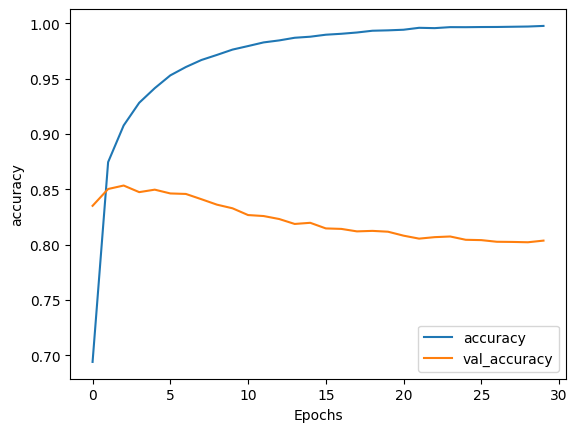

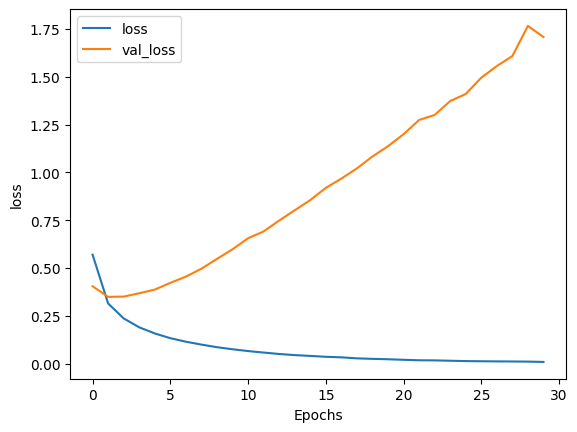

In [24]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Visualize Word Embeddings

As before, you can visualize the final weights of the embeddings using the [Tensorflow Embedding Projector](https://projector.tensorflow.org/).

In [25]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)


(10000, 16)


In [26]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

In [27]:
# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Wrap Up

In this lab, you were able to build a binary classifier to detect sarcasm. You saw some overfitting in the initial attempt and hopefully, you were able to arrive at a better set of hyperparameters.

So far, you've been tokenizing datasets from scratch and you're treating the vocab size as a hyperparameter. Furthermore, you're tokenizing the texts by building a vocabulary of full words. In the next lab, you will make use of a pre-tokenized dataset that uses a vocabulary of *subwords*. For instance, instead of having a uniqe token for the word `Tensorflow`, it will instead have a token each for `Ten`, `sor`, and `flow`. You will see the motivation and implications of having this design in the next exercise. See you there!